In [1]:
import warnings
import tqdm
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from shapely.geometry import Polygon

sns.set_theme(style="whitegrid")
warnings.filterwarnings('ignore')

In [2]:
def calculate_compactness(cluster_res):
    compactness_res = cluster_res.area * 4 * np.pi / (cluster_res.boundary.length**2)
    compactness_res  = compactness_res.to_frame().reset_index().rename(columns={0:'compactness','index':'clus'})
    return compactness_res

In [3]:
municipalities = gpd.read_file('/data/processed_data/municipalities/municipalities.geojson')
muni_list = list(municipalities.Kode.unique())
len(muni_list)

98

## Figure 1: Distribution of Compactness

#### Method: polygon clustering, Rook contiguity + interpolated values

In [4]:
method = "polygons_compact_rook_interpolated"

In [5]:
df_compactness_list = []
for m in tqdm.tqdm(muni_list):
    cluster_res = gpd.read_file(f"/data/results/{method}/geometries/Kode_{m}.geojson")
    df_compactness = calculate_compactness(cluster_res).assign(Kode=m)
    df_compactness_list.append(df_compactness)
df_compactness_all = pd.concat(df_compactness_list)

100%|███████████████████████████████████████████| 98/98 [00:22<00:00,  4.41it/s]


Text(0.5, 0.98, 'Distribution of Compactness Values across All Municipalities')

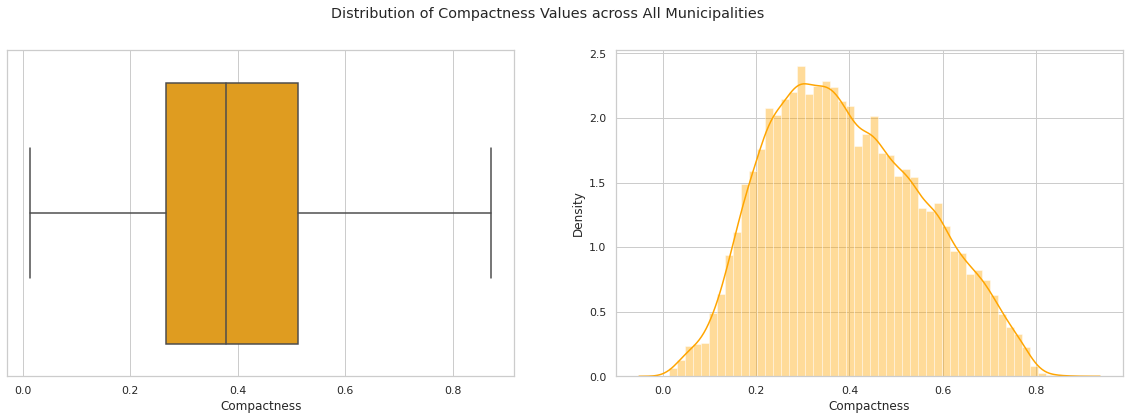

In [6]:
fig, ax = plt.subplots(1,2,figsize=(20, 6))
sns.boxplot(df_compactness_all.compactness, color='orange', ax=ax[0])
sns.distplot(df_compactness_all.compactness, color='orange', ax=ax[1])
ax[0].set_xlabel('Compactness')
ax[1].set_xlabel('Compactness')
plt.suptitle('Distribution of Compactness Values across All Municipalities')

In [8]:
df_compactness_all.compactness.describe()

count    24548.000000
mean         0.393144
std          0.163433
min          0.014292
25%          0.266647
50%          0.377443
75%          0.512843
max          0.871613
Name: compactness, dtype: float64

In [7]:
# previous
df_compactness_all.compactness.describe()

count    25635.000000
mean         0.349614
std          0.154125
min          0.021769
25%          0.229833
50%          0.324892
75%          0.451718
max          0.838411
Name: compactness, dtype: float64

In [9]:
# lowest 2% compactness value cutoff
df_compactness_all.compactness.quantile(0.02)

0.1076120624607917

## Figure 2: Clusters with Lowest Compactness

#### Method: polygon clustering, Rook contiguity + interpolated values

In [10]:
compactness_cutoff = 0.1
lowest_compactness_clusters = df_compactness_all[df_compactness_all.compactness<=compactness_cutoff]
len(lowest_compactness_clusters), len(lowest_compactness_clusters)/len(df_compactness_all)

(392, 0.015968714355548315)

In [11]:
df_lowest_compactness_list = []
for m in tqdm.tqdm(muni_list):
    cluster_res = gpd.read_file(f"/data/results/{method}/geometries/Kode_{m}.geojson")
    clus_ids = lowest_compactness_clusters[lowest_compactness_clusters.Kode==m].clus.to_list()
    cluster_res_sub = cluster_res[cluster_res.max_p.isin(clus_ids)][['max_p','min_val','geometry']].assign(Kode=m)
    df_lowest_compactness_list.append(cluster_res_sub)
df_lowest_compactness = pd.concat(df_lowest_compactness_list)

100%|███████████████████████████████████████████| 98/98 [00:17<00:00,  5.45it/s]


<AxesSubplot:>

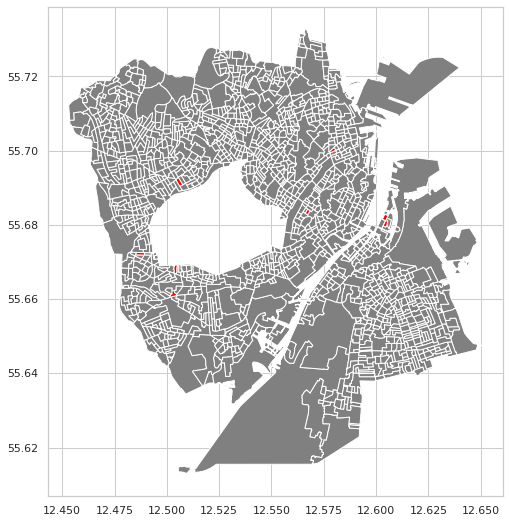

In [12]:
# plot on a map
kode = 101
fig, ax = plt.subplots(1,1,figsize=(9,9))
gpd.read_file(f"/data/results/{method}/geometries/Kode_{kode}.geojson").plot(color='grey',ax=ax)
df_lowest_compactness[df_lowest_compactness.Kode==kode].plot(color='red',ax=ax)

<AxesSubplot:>

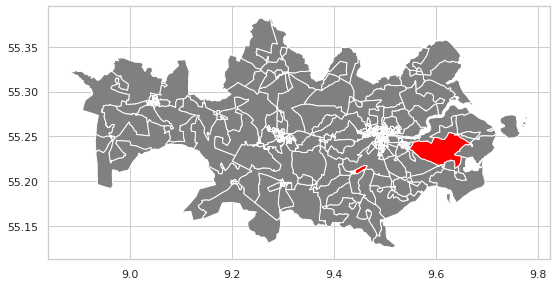

In [13]:
kode = 510
fig, ax = plt.subplots(1,1,figsize=(9,9))
gpd.read_file(f"/data/results/{method}/geometries/Kode_{kode}.geojson").plot(color='grey',ax=ax)
df_lowest_compactness[df_lowest_compactness.Kode==kode].plot(color='red',ax=ax)

<AxesSubplot:>

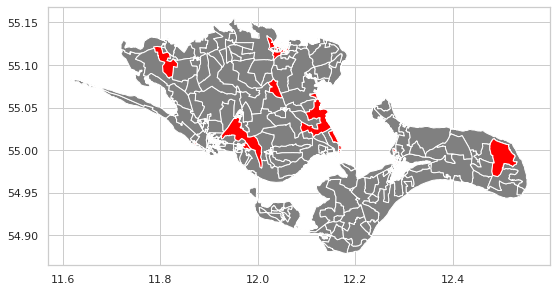

In [14]:
kode = 390
fig, ax = plt.subplots(1,1,figsize=(9,9))
gpd.read_file(f"/data/results/{method}/geometries/Kode_{kode}.geojson").plot(color='grey',ax=ax)
df_lowest_compactness[df_lowest_compactness.Kode==kode].plot(color='red',ax=ax)

In [15]:
# df_lowest_compactness.to_file(f"/data/results/{method}/cluster_w_lowest_2percentile_compactness_v0322.geojson", driver='GeoJSON')

## Table 1: Metrics by Municipality 

#### By municipality
1. number of clusters
2. summary stats of compactness
2. summary stats of min_val
3. summary stats of cluster area

In [16]:
def get_metrics_for_one_muni(cluster_res, kode_id, area_crs='3857', method='polygon'):
    compactness_res = calculate_compactness(cluster_res)
    
    # number of clusters compacness summary stats
    compactness_stats = compactness_res.compactness.describe().to_frame().T.add_prefix('compactness_').rename(
        columns={'compactness_count':'count_clusters'}
    )
    
    # min_val summary stats
    min_val_stats = cluster_res.min_val.describe().to_frame().T.drop('count', axis=1).add_prefix('min_val_')
    
    # area (in sq meters) summary stats
    cluster_res = cluster_res.to_crs(f"EPSG:{area_crs}")
    cluster_res['area'] = cluster_res.geometry.area
    area_stats = cluster_res['area'].describe().to_frame().T.drop('count', axis=1).add_prefix('area_meter_')
      
    # combine metrics
    res = pd.concat([
        compactness_stats.reset_index(drop=True),
        min_val_stats.reset_index(drop=True),
        area_stats.reset_index(drop=True)
    ],axis=1)
    res.insert(0, "method", method)
    res.insert(0, "Kode", m)
    
    return res

In [19]:
method_list = [
    'polygons_queen',
    'polygons_rook',
    'polygons_compact_rook',
    'polygons_queen_interpolated',
    'polygons_rook_interpolated',
    'polygons_compact_rook_interpolated',
]
result_dict = {}
for method in method_list:
    print(method)
    result_dir = f"/data/results/{method}"
    metrics_list = []
    for m in tqdm.tqdm(muni_list):
        cluster_res = gpd.read_file(f"{result_dir}/geometries/Kode_{m}.geojson")
        metrics = get_metrics_for_one_muni(cluster_res, kode_id=m, method=method)
        metrics_list.append(metrics)
    full_metrics_res = pd.concat(metrics_list).sort_values('Kode').reset_index(drop=True)
    result_dict[method] = full_metrics_res

polygons_queen


100%|███████████████████████████████████████████| 98/98 [00:33<00:00,  2.97it/s]


polygons_rook


100%|███████████████████████████████████████████| 98/98 [00:31<00:00,  3.07it/s]


polygons_compact_rook


100%|███████████████████████████████████████████| 98/98 [00:29<00:00,  3.28it/s]


polygons_queen_interpolated


100%|███████████████████████████████████████████| 98/98 [00:33<00:00,  2.89it/s]


polygons_rook_interpolated


100%|███████████████████████████████████████████| 98/98 [00:33<00:00,  2.96it/s]


polygons_compact_rook_interpolated


100%|███████████████████████████████████████████| 98/98 [00:30<00:00,  3.17it/s]


In [20]:
metrics_polygons_queen = result_dict['polygons_queen']
metrics_polygons_rook = result_dict['polygons_rook']
metrics_polygons_compact_rook = result_dict['polygons_compact_rook']
metrics_polygons_queen_interpolated = result_dict['polygons_queen_interpolated']
metrics_polygons_rook_interpolated = result_dict['polygons_rook_interpolated']
metrics_polygons_compact_rook_interpolated = result_dict['polygons_compact_rook_interpolated']

In [21]:
all_metrics = pd.concat([
    metrics_polygons_queen,
    metrics_polygons_rook,
    metrics_polygons_compact_rook,
    metrics_polygons_queen_interpolated,
    metrics_polygons_rook_interpolated,
    metrics_polygons_compact_rook_interpolated
])
all_metrics.columns

Index(['Kode', 'method', 'count_clusters', 'compactness_mean',
       'compactness_std', 'compactness_min', 'compactness_25%',
       'compactness_50%', 'compactness_75%', 'compactness_max', 'min_val_mean',
       'min_val_std', 'min_val_min', 'min_val_25%', 'min_val_50%',
       'min_val_75%', 'min_val_max', 'area_meter_mean', 'area_meter_std',
       'area_meter_min', 'area_meter_25%', 'area_meter_50%', 'area_meter_75%',
       'area_meter_max'],
      dtype='object')

In [22]:
all_metrics.groupby('method')[['compactness_mean']].mean()

,compactness_mean
method,
polygons_compact_rook,0.379446
polygons_compact_rook_interpolated,0.379004
polygons_queen,0.320888
polygons_queen_interpolated,0.321548
polygons_rook,0.332067
polygons_rook_interpolated,0.333595


In [23]:
all_metrics.groupby('method')[['area_meter_mean']].mean()

,area_meter_mean
method,
polygons_compact_rook,6.875590e+06
polygons_compact_rook_interpolated,6.666382e+06
polygons_queen,6.685217e+06
polygons_queen_interpolated,6.374430e+06
polygons_rook,6.710887e+06
polygons_rook_interpolated,6.410738e+06


In [24]:
all_metrics.groupby('method')[['min_val_mean']].mean()

,min_val_mean
method,
polygons_compact_rook,82.656681
polygons_compact_rook_interpolated,81.293891
polygons_queen,78.233726
polygons_queen_interpolated,76.674438
polygons_rook,78.535563
polygons_rook_interpolated,77.131105


In [25]:
all_metrics.groupby('method')[['count_clusters']].mean()

,count_clusters
method,
polygons_compact_rook,241.112245
polygons_compact_rook_interpolated,250.489796
polygons_queen,251.000000
polygons_queen_interpolated,263.040816
polygons_rook,249.938776
polygons_rook_interpolated,261.581633


In [26]:
all_metrics

,Kode,method,count_clusters,compactness_mean,compactness_std,compactness_min,compactness_25%,compactness_50%,compactness_75%,compactness_max,...,min_val_50%,min_val_75%,min_val_max,area_meter_mean,area_meter_std,area_meter_min,area_meter_25%,area_meter_50%,area_meter_75%,area_meter_max
0,101,polygons_queen,1419.0,0.479517,0.159694,0.059202,0.359649,0.491651,0.610425,0.806444,...,119.500000,203.500000,1390.000000,2.013194e+05,9.319217e+05,12367.054280,49141.544707,8.559852e+04,1.546094e+05,2.785957e+07
1,147,polygons_queen,276.0,0.483025,0.149623,0.172803,0.369487,0.491455,0.603969,0.815968,...,121.500000,207.250000,1244.500000,9.897778e+04,1.268929e+05,14703.824228,41514.336994,6.642492e+04,1.031390e+05,1.167646e+06
2,151,polygons_queen,198.0,0.354407,0.162539,0.073017,0.216843,0.342466,0.455940,0.762660,...,71.000000,101.875000,698.000000,5.385198e+05,1.124923e+06,20370.545774,130774.030827,2.162644e+05,4.348041e+05,1.019911e+07
3,153,polygons_queen,132.0,0.401936,0.149964,0.121616,0.266466,0.398794,0.504467,0.737106,...,79.750000,118.375000,402.000000,4.979127e+05,9.712605e+05,19292.564757,106054.335495,1.745003e+05,3.522252e+05,5.728540e+06
4,155,polygons_queen,73.0,0.357393,0.165525,0.061913,0.249322,0.331821,0.459415,0.720339,...,61.000000,78.500000,196.500000,7.869791e+05,2.317430e+06,40275.443439,127707.984172,1.821974e+05,2.804451e+05,1.811976e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,840,polygons_compact_rook_interpolated,141.0,0.338637,0.138199,0.091027,0.236876,0.332764,0.422540,0.765566,...,61.662661,80.484599,226.640371,1.471694e+07,1.832311e+07,109946.370712,363077.933280,2.093527e+06,2.690445e+07,7.739790e+07
94,846,polygons_compact_rook_interpolated,204.0,0.334664,0.135676,0.055990,0.229010,0.327156,0.430759,0.783738,...,63.669880,80.265019,301.534278,1.174636e+07,1.822811e+07,85938.268694,295326.420387,1.160075e+06,1.761517e+07,7.694447e+07
95,849,polygons_compact_rook_interpolated,188.0,0.345551,0.152695,0.049801,0.229893,0.334197,0.429777,0.761108,...,60.868098,81.162055,192.249484,1.561751e+07,3.236702e+07,95669.865974,296388.228860,1.075597e+06,1.639588e+07,2.323219e+08
96,851,polygons_compact_rook_interpolated,878.0,0.396189,0.165236,0.038666,0.269250,0.379327,0.511658,0.843484,...,69.685230,102.595865,457.371811,4.334406e+06,1.427619e+07,34821.497314,156507.138275,2.639565e+05,8.573584e+05,2.511888e+08


## Table 2: Metrics by Cluster

#### By cluster
1. compactness of each cluster
2. sum of min_val of each cluster
3. area of each cluster

In [28]:
method_list = [
    'polygons_queen',
    'polygons_rook',
    'polygons_compact_rook',
    'polygons_queen_interpolated',
    'polygons_rook_interpolated',
    'polygons_compact_rook_interpolated',
]

In [29]:
result_dict = {}
for method in method_list:
    print(method)
    result_dir = f"/data/results/{method}"
    cluster_metrics_list = []
    for m in tqdm.tqdm(muni_list):
        cluster_res = gpd.read_file(f"{result_dir}/geometries/Kode_{m}.geojson")
        cluster_res_sub = cluster_res[['max_p','min_val', 'geometry']]
        cluster_res_sub["area"] = cluster_res_sub.geometry.area
        cluster_res_sub = cluster_res_sub.to_crs('EPSG:3857')
        cluster_res_sub["area_meter"] = cluster_res_sub.geometry.area
        cluster_metrics = cluster_res_sub.merge(
            calculate_compactness(cluster_res).rename(columns={'clus':'max_p'}),
            how='left', on='max_p'
        ).drop('geometry',axis=1).assign(Kode=m)
        cluster_metrics_list.append(cluster_metrics)
    full_cluster_metrics_res = pd.concat(cluster_metrics_list).sort_values(['Kode','max_p']).reset_index(drop=True)
    full_cluster_metrics_res.to_csv(f'{result_dir}/cluster_metrics.csv', index=False)

polygons_queen


100%|███████████████████████████████████████████| 98/98 [00:32<00:00,  3.02it/s]


polygons_rook


100%|███████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


polygons_compact_rook


100%|███████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s]


polygons_queen_interpolated


100%|███████████████████████████████████████████| 98/98 [00:33<00:00,  2.91it/s]


polygons_rook_interpolated


100%|███████████████████████████████████████████| 98/98 [00:32<00:00,  3.00it/s]


polygons_compact_rook_interpolated


100%|███████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


In [30]:
full_cluster_metrics_res

,max_p,min_val,area,area_meter,compactness,Kode
0,1,121.599407,0.000003,5.561661e+04,0.253087,101
1,2,173.971496,0.000121,2.655682e+06,0.100494,101
2,3,184.535352,0.000019,4.182873e+05,0.577631,101
3,4,174.960211,0.000005,1.207279e+05,0.384033,101
4,5,97.112060,0.000004,7.925460e+04,0.519171,101
...,...,...,...,...,...,...
24543,323,58.457192,0.000010,2.368363e+05,0.537017,860
24544,324,62.987938,0.000006,1.316697e+05,0.292692,860
24545,325,72.293419,0.000008,1.918396e+05,0.603910,860
24546,326,51.914055,0.000004,9.947353e+04,0.279486,860
